In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

print(tf.__version__)

2.9.1


In [4]:
# load raw data and check successful import
raw_dataset = pd.read_csv('m1-6 fluid.csv', na_values='?', skipinitialspace=True)
raw_dataset.head()

,m,repulsive,T*,gamma*
0,1,8,0.5000,2.7775
1,1,8,0.5026,2.7708
2,1,8,0.5051,2.7642
3,1,8,0.5077,2.7575
4,1,8,0.5103,2.7509


In [6]:
#split training and testing sets

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
m,8953.0,3.539931,1.700220,1.0000,2.00000,4.00000,5.000000,6.0000
repulsive,8953.0,12.495700,4.568661,8.0000,8.00000,12.00000,12.000000,20.0000
T*,8953.0,1.700161,0.691436,0.5026,1.17454,1.57496,2.120637,4.0683
gamma*,8953.0,0.544374,0.476429,0.0000,0.16023,0.44057,0.792545,2.7708


In [8]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('gamma*')
test_labels = test_features.pop('gamma*')

In [9]:
# investigate variation
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
m,3.539931,1.700220
repulsive,12.495700,4.568661
T*,1.700161,0.691436
gamma*,0.544374,0.476429


In [10]:
#normalise data
normaliser = tf.keras.layers.Normalization(axis=-1)

In [11]:
normaliser.adapt(np.array(train_features))

In [12]:
print(normaliser.mean.numpy())

[[ 3.54  12.496  1.7  ]]


In [13]:
# demonstration of normalisation on row 1
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalised:', normaliser(first).numpy())

First example: [[6.   8.   3.89]]

Normalised: [[ 1.45 -0.98  3.17]]


In [14]:
# Regression with ANN
# define model build and compilation function


def build_and_compile_model(norm):
    model = keras.Sequential([norm, layers.Dense(28, activation='selu'),
                             layers.Dense(13, activation='tanh'),
                             layers.Dense(1, activation = 'linear')])
    
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.0025))
    return model

In [15]:
m1to6_model = build_and_compile_model(normaliser)
m1to6_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 28)                112       
                                                                 
 dense_1 (Dense)             (None, 13)                377       
                                                                 
 dense_2 (Dense)             (None, 1)                 14        
                                                                 
Total params: 510
Trainable params: 503
Non-trainable params: 7
_________________________________________________________________


In [16]:
# plot loss and validation loss against epochs elapsed
def plot_loss(history):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlim([0,25])
    plt.ylim([0,0.0025])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)

In [17]:
history = m1to6_model.fit(
          train_features,
          train_labels,
          validation_split=0.2,
          verbose=0, epochs=25)

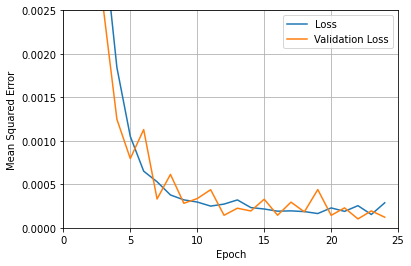

In [18]:
plot_loss(history)

In [19]:
# find numerical values for loss and validation loss
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist[20:]

,loss,val_loss,epoch
10,0.000296,0.000336,10
11,0.000250,0.000438,11
12,0.000273,0.000144,12
13,0.000320,0.000225,13
14,0.000233,0.000193,14
15,0.000216,0.000328,15
16,0.000191,0.000145,16
17,0.000195,0.000295,17
18,0.000186,0.000183,18
19,0.000164,0.000440,19


70/70 [==============================] - 0s 1ms/step


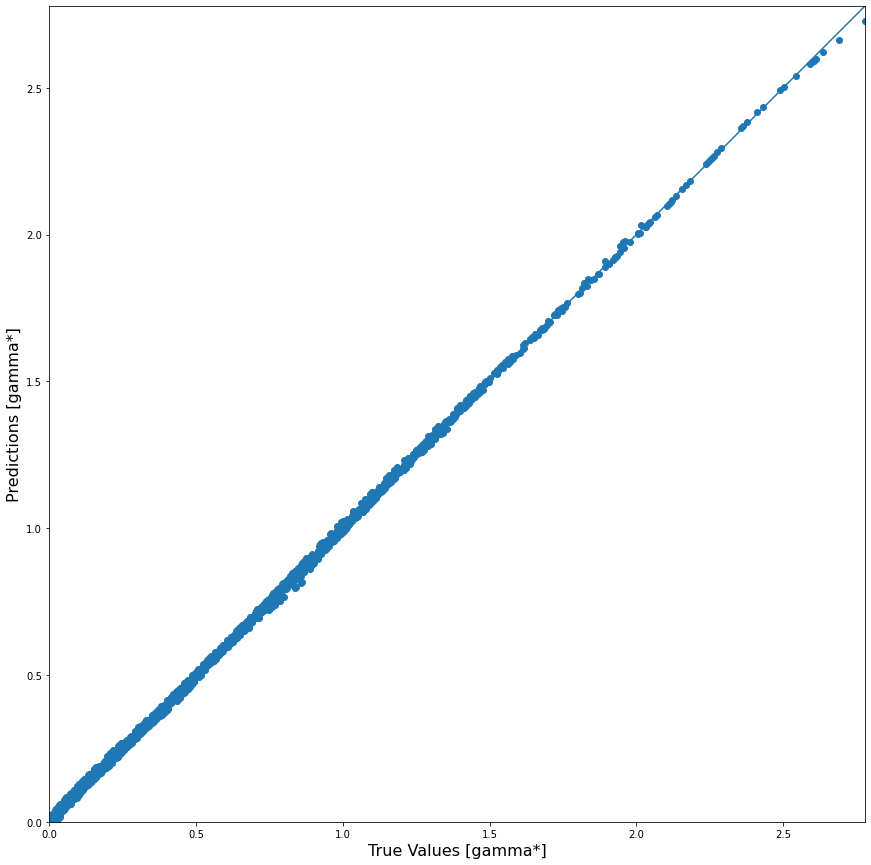

In [20]:
# plot predicted values against true values
test_predictions = m1to6_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [gamma*]', fontsize=16)
plt.ylabel('Predictions [gamma*]', fontsize=16)
lims = [0,test_labels.max()]
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [21]:
# calculate r-squared

metric = tfa.metrics.r_square.RSquare()
metric.update_state(test_labels, test_predictions)
result = metric.result()
result.numpy()

0.9995422

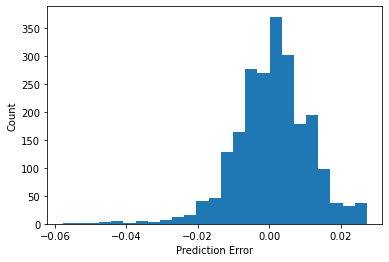

In [22]:
# plot error distribution

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [23]:
# save the produced model
m1to6_model.save('m1to6 model')

INFO:tensorflow:Assets written to: m1to6 model\assets
